
<h2 id="Hidden-Markov-Model-Filter-for-Portfolio-Allocation-Methods">Hidden Markov Model Filter for Portfolio Allocation Methods<a class="anchor-link" href="#Hidden-Markov-Model-Filter-for-Portfolio-Allocation-Methods">¶</a></h2><h3 id="Author:-Steven-Struglia">Author: Steven Struglia<a class="anchor-link" href="#Author:-Steven-Struglia">¶</a></h3><p>Suppose that a Hidden Markov Model (HMM) has $N$ distinct hidden states denoted by $S_{1},...,S_{N}$ and M distinct observation symbols per state denoted by $v_{1},...,v_{m}$</p>
<p>The state at time $t: q_{t} \in \{S_{1},...,S_{n}\} $</p>
<p>The output at time $t: O_{t} \in \{v_{1},..,v_{M}\}$</p>
<p>The transition probability matrix: $A = [a_{ij}]_{i,j=1}^{N}$, where</p>
<p>$a_{ij} = P[q_{t+1} = S_{j} | q_{t} = S_{i}] \geq 0$</p>
<p>The emission probability matrix: $B = [b_{i}(k)]_{i=1, k=1}^{N,M}$, where</p>
<p>$b_{i}(k) = P[O_{t} = v_{k} | q_{t} = S_{i}], 1 \leq j \leq N, 1 \leq k \leq M $</p>
<p>The initial state distribution $\pi = [\pi_{i}]_{i=1}^{M}$, where $\pi_{i} = P[q_{1} = S_{i}], 1 \leq i \leq N$</p>
<p>Since a multinomial HMM can be completely determined by three probability measures A, B, and $\pi$,
for convenience, we use the compact notation $\lambda = (A,B,\pi)$</p>
<p>X: states, y: possible observations, a: transition probabilities, b: emission probabilities</p>


In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
os.chdir('..')
from sifinfra import sif_utils as su
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')


<h4 id="Grabbing-data-and-features-to-be-used-by-the-HMM-for-training">Grabbing data and features to be used by the HMM for training<a class="anchor-link" href="#Grabbing-data-and-features-to-be-used-by-the-HMM-for-training">¶</a></h4>


In [3]:
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
top_n = 200
tickers = sorted(su.get_universe_tickers(top_n, start_date, end_date))
price_attrs = ['date','close', 'open', 'high', 'low']
data = su.get_equity_data(tickers, start_date, end_date, price_attrs)
data['close'].shape

/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:321: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternativ

(252, 222)


<h4 id="Training-function-for-HMM-to-compute-states-and-store-in-pkl-file">Training function for HMM to compute states and store in pkl file<a class="anchor-link" href="#Training-function-for-HMM-to-compute-states-and-store-in-pkl-file">¶</a></h4><p>Compute features to feed into HMM, train and group HMM state parameters individually based on mean and variance obtained from K-Means, store .pkl for HMM</p>


In [4]:
import time
import pickle
from hmmlearn.hmm import GMMHMM
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

def compute_states(data,ticker):
    price_attrs = ['open', 'close', 'high', 'low']
    temp_data = pd.DataFrame()
    for a in price_attrs:
        temp_data[a] = data[a][ticker].values
    X = pd.DataFrame()
    X['date'] = temp_data['close'].index
    for i in ['open', 'high', 'low', 'close']:
        X[i] = temp_data[i].values.astype(float)
    
    X['CO'] = (X['close'] - X['open'])/X['open']
    X['HO'] = (X['high'] - X['open'])/X['open']
    X['OL'] = (X['open'] - X['low'])/X['open']
    X.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)
    
    n_days = X.shape

    n = 80
    X_train = X.head(int(len(X)*(n/100)))
    X_test = X.tail(int(len(X)*((100-n)/100)))

    n_states = 4

    X_clusters = KMeans(n_clusters=n_states)
    fitted_X = X_clusters.fit(np.array(X_train['CO']).reshape(-1,1))
    means = fitted_X.cluster_centers_
    X_train['cluster'] = fitted_X.labels_

    cluster_arrays = [np.array(X_train[X_train['cluster'] == i]['CO']) for i in list(set(fitted_X.labels_))]
    total_cluster = float(len(X_train)) 
    total_GMM_params = []

    for cluster in cluster_arrays:
        GMM_params = []
        covar = np.cov(cluster.T)
        GMM_params.append(covar)
        total_GMM_params.append(GMM_params)

    for i in range(len(means)):
        total_GMM_params[i].append(means[i])


    hmm = GMMHMM(n_components=n_states, covariance_type="full", n_iter=1000, algorithm='map')
    hmm.gmms_ = [GMM(n_components = n_states)] * n_states

    for i, GMM_i in enumerate(hmm.gmms_):
        GMM_i.covars_ = np.array(total_GMM_params[i][0])
        GMM_i.means_ = np.array(total_GMM_params[i][1])
        print("GMM {}:".format(i+1),"Variance = {}".format(GMM_i.covars_), "Mean = {}".format(GMM_i.means_))

    hmm.fit(X_train[['CO', 'HO', 'OL']])
    total_latent_states = hmm.predict(X[['CO', 'HO', 'OL']])
    latent_states_sequence = hmm.predict(X_test[['CO', 'HO', 'OL']])
    hmm.fit(X_test[['CO', 'HO', 'OL']])
    
    
#     filename = 'sif/sifinsights/HMM/{}_HMM.pkl'.format(ticker)
#     with open(filename, 'wb') as handle:
#         pickle.dump(hmm, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    return total_latent_states, latent_states_sequence, hmm

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



<h4 id="Example-run-of-compute_states-run-on-the-'AMZN'-ticker">Example run of compute_states run on the 'AMZN' ticker<a class="anchor-link" href="#Example-run-of-compute_states-run-on-the-'AMZN'-ticker">¶</a></h4>


In [5]:
compute_states(data,'AMZN')

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GMM 1: Variance = 1.4958138993668075e-05 Mean = [0.00403956]
GMM 2: Variance = 1.1965836741201984e-05 Mean = [-0.00721774]
GMM 3: Variance = 6.227753883541853e-05 Mean = [0.02102517]
GMM 4: Variance = 4.4894673721338586e-05 Mean = [-0.02244961]


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


(array([3, 1, 3, 3, 1, 0, 0, 1, 1, 3, 1, 0, 2, 1, 1, 0, 2, 1, 1, 3, 3, 1,
        1, 0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2,
        1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2,
        0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 0, 2, 2,
        1, 1, 1, 1, 3, 3, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 3, 3, 3,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2,
        2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2,
        2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0,
        0, 2, 2, 1, 0, 2, 0, 0, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0,
        2, 2, 0, 2, 2, 0, 3, 1, 1, 0]),
 array([3, 2, 0, 0, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2


<h4 id="Compute-trained-HMM-state-table-to-analyze-state-behavior">Compute trained HMM state table to analyze state behavior<a class="anchor-link" href="#Compute-trained-HMM-state-table-to-analyze-state-behavior">¶</a></h4>


In [6]:
%%capture
train_state_table = pd.DataFrame()
for ticker in tickers:
    try:
        tls, lss, _ = compute_states(data,ticker);
        train_state_table[ticker] = tls
    except:
        pass

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
train_state_table.head(20)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AAPL,ABB,ABBV,ABT,ACN,ADBE,ADI,ADP,AEP,AFL,...,VMW,VRTX,VZ,WBA,WDAY,WFC,WM,WMT,XOM,ZTS
0,2,0,2,2,3,2,3,2,1,1,...,0,0,3,2,2,0,0,3,2,1
1,3,3,2,2,2,0,2,0,1,2,...,3,1,1,1,0,1,1,2,3,3
2,0,0,3,0,3,2,3,2,3,3,...,0,0,1,2,2,0,2,0,2,0
3,0,0,0,0,2,3,3,0,0,1,...,0,2,1,0,2,1,2,3,2,0
4,0,3,0,2,2,3,3,2,3,2,...,1,2,1,0,2,2,2,1,0,2
5,0,3,2,0,3,3,3,2,1,3,...,2,2,3,0,3,2,1,1,0,1
6,0,0,3,0,3,2,0,1,3,0,...,1,2,2,0,1,0,0,3,0,1
7,1,0,1,0,3,3,3,3,2,3,...,1,2,2,1,1,0,0,0,0,1
8,1,0,2,1,1,3,1,3,0,0,...,3,1,0,1,3,0,3,0,1,1
9,2,3,1,0,1,2,0,1,3,0,...,0,2,2,0,1,2,0,0,3,1


In [8]:
train_state_table.isna().all().all()

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False


<h4 id="State-Decision-function-for-a-given-ticker-and-trained-HMM-state-table">State Decision function for a given ticker and trained HMM state table<a class="anchor-link" href="#State-Decision-function-for-a-given-ticker-and-trained-HMM-state-table">¶</a></h4><p>$\color{SpringGreen}{States}$ = $\{s_{i}: i \in \{1,..,N\}\}$</p>
<p>$\color{Aqua}{Buy}$: $\{s_{i}$: cumulative_log_return $(s_{i}) &gt; 1.1\}$</p>
<p>$\color{Violet}{Sell}$: $\{s_{i}$: cumulative_log_return $(s_{i}) \leq 0.9\}$</p>
<p>$\color{MediumPurple}{Hold}$: $\{s_{i}$: cumulative_log_return$(s_{i}) \leq 1.1$ and $&gt; 0.9\}$</p>


In [9]:
def state_decision(data, ticker, state_table, n_states):
    logreturn = np.log(data['close'][ticker]) - np.log(data['close'][ticker].shift(1)).fillna(0).values
    log_data = pd.DataFrame([logreturn.values, train_state_table[ticker].values]).T
    state_returns = pd.DataFrame(logreturn)
    for i in range(n_states):
        state = (train_state_table[ticker] == i)
        idx = np.append(0,state[:-1])
        state_returns['state %d_return'%i] = logreturn.multiply(idx,axis = 0)
    cumsum_df = np.exp(state_returns.cumsum())
    cumsum_values = cumsum_df.tail(1).values.tolist()[0]
#     print(cumsum_values)
    buy = [i for i,val in enumerate(cumsum_values) if val > 1.1]
    sell = [i for i,val in enumerate(cumsum_values) if val <= 0.9]
    hold = [i for i,val in enumerate(cumsum_values) if val <= 1.1 and val > 0.9]
    decisions = state_table[ticker].apply(lambda x: 'buy' if x in buy else 'sell' if x in sell else 'hold')
#     print("Buy:{}".format(buy))
#     print("Sell:{}".format(sell))
#     print("Hold:{}".format(hold))
    return decisions, buy


<h4 id="Example-run-of-state_decision-function-on-'AMZN'-ticker">Example run of state_decision function on 'AMZN' ticker<a class="anchor-link" href="#Example-run-of-state_decision-function-on-'AMZN'-ticker">¶</a></h4>


In [10]:
state_decision(data,'AMZN', train_state_table, 4)

(0       buy
 1      hold
 2       buy
 3       buy
 4      hold
        ... 
 247    hold
 248     buy
 249    hold
 250    hold
 251    hold
 Name: AMZN, Length: 252, dtype: object,
 [0, 4])


<h4 id="Convert-state-table-into-decision-table">Convert state table into decision table<a class="anchor-link" href="#Convert-state-table-into-decision-table">¶</a></h4>


In [11]:
def compute_filter(data, state_table, n_states):
    f = pd.DataFrame()
    for ticker in state_table.columns:
        f[ticker],_ = state_decision(data, ticker, train_state_table, n_states)
    return f

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
f = compute_filter(data, train_state_table, 4)

In [13]:
f

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AAPL,ABB,ABBV,ABT,ACN,ADBE,ADI,ADP,AEP,AFL,...,VMW,VRTX,VZ,WBA,WDAY,WFC,WM,WMT,XOM,ZTS
0,buy,buy,hold,hold,hold,buy,buy,buy,hold,buy,...,buy,buy,hold,sell,hold,buy,buy,hold,sell,buy
1,hold,buy,hold,hold,buy,buy,buy,buy,hold,sell,...,buy,hold,sell,sell,buy,sell,hold,hold,hold,buy
2,buy,buy,hold,buy,hold,buy,buy,buy,buy,hold,...,buy,buy,sell,sell,hold,buy,buy,buy,sell,buy
3,buy,buy,buy,buy,buy,hold,buy,buy,buy,buy,...,buy,buy,sell,buy,hold,sell,buy,hold,sell,buy
4,buy,buy,buy,hold,buy,hold,buy,buy,buy,sell,...,sell,buy,sell,buy,hold,buy,buy,buy,buy,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,buy,hold,sell,buy,buy,buy,hold,hold,hold,buy,...,sell,hold,buy,buy,sell,sell,hold,buy,buy,buy
248,buy,hold,sell,hold,buy,buy,hold,hold,hold,buy,...,sell,buy,buy,buy,sell,buy,hold,buy,hold,buy
249,hold,hold,sell,hold,buy,buy,buy,hold,buy,hold,...,sell,buy,buy,buy,sell,sell,buy,buy,hold,buy
250,buy,hold,sell,hold,buy,buy,hold,hold,hold,buy,...,sell,hold,buy,sell,sell,sell,hold,hold,hold,buy



<h4 id="Filtering-of-stock-universe-for-MQU-strategy-using-trained-state-table">Filtering of stock universe for MQU strategy using trained state table<a class="anchor-link" href="#Filtering-of-stock-universe-for-MQU-strategy-using-trained-state-table">¶</a></h4>



<p>Split time data into chunks of equal size, these will be the training batches for the HMM's</p>
<p>First batch: Trained HMM states (we already have this segment of data from above)</p>
<p>Second batch: Construct filtered and unfiltered MQU portfolio weights</p>
<p>Third batch: Evaluate strategies</p>


In [14]:
def split_dataframe(df, chunk_size): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

X = data['close'].pct_change().fillna(0)

intervals = split_dataframe(X, chunk_size = 84)
state_split_table = split_dataframe(f, chunk_size = 84)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



<p>intervals is a size 3 array of dataframe batches of daily returns calculated from close price</p>
<p>state_split_table is a size 3 array of dataframe batches of trained state decisions for each ticker</p>



<h3 id="Normalized-Maximum-Quadratic-Utility-(MQU)-Portfolio-using-L2-Regularizer:">Normalized Maximum Quadratic Utility (MQU) Portfolio using L2 Regularizer:<a class="anchor-link" href="#Normalized-Maximum-Quadratic-Utility-(MQU)-Portfolio-using-L2-Regularizer:">¶</a></h3><h4 id="Normalizing-a-matrix-M:-$\mu_{t}-=-\frac{1}{N}\sum_{1,..,N}x_{i,t}$-$\to$-normalized(M)-=-M---$\mu$">Normalizing a matrix M: $\mu_{t} = \frac{1}{N}\sum_{1,..,N}x_{i,t}$ $\to$ normalized(M) = M - $\mu$<a class="anchor-link" href="#Normalizing-a-matrix-M:-$\mu_{t}-=-\frac{1}{N}\sum_{1,..,N}x_{i,t}$-$\to$-normalized(M)-=-M---$\mu$">¶</a></h4><h4 id="Convex-Optimization-Problem-for-long-only-MQU-Portfolio:">Convex Optimization Problem for long-only MQU Portfolio:<a class="anchor-link" href="#Convex-Optimization-Problem-for-long-only-MQU-Portfolio:">¶</a></h4><h4 id="$\max\limits_{w}\{\color{Aqua}{w^{T}\mu}---\color{GreenYellow}{\delta}\color{Violet}{w^{T}\Sigma-w}---\color{MediumSpringGreen}{\gamma}\color{MediumPurple}{||w||_{2}}\}$-subject-to-constraints-$\color{LightCoral}{\substack{\sum_{i}w_{i}-=-1-\\-w_{i}-&gt;-0}},-i-\in-\{1,..,N\}$-and-coefficients-$\color{GreenYellow}{\delta},-\color{MediumSpringGreen}{\gamma}$">$\max\limits_{w}\{\color{Aqua}{w^{T}\mu} - \color{GreenYellow}{\delta}\color{Violet}{w^{T}\Sigma w} - \color{MediumSpringGreen}{\gamma}\color{MediumPurple}{||w||_{2}}\}$ subject to constraints $\color{LightCoral}{\substack{\sum_{i}w_{i} = 1 \\ w_{i} &gt; 0}}, i \in \{1,..,N\}$ and coefficients $\color{GreenYellow}{\delta}, \color{MediumSpringGreen}{\gamma}$<a class="anchor-link" href="#$\max\limits_{w}\{\color{Aqua}{w^{T}\mu}---\color{GreenYellow}{\delta}\color{Violet}{w^{T}\Sigma-w}---\color{MediumSpringGreen}{\gamma}\color{MediumPurple}{||w||_{2}}\}$-subject-to-constraints-$\color{LightCoral}{\substack{\sum_{i}w_{i}-=-1-\\-w_{i}-&gt;-0}},-i-\in-\{1,..,N\}$-and-coefficients-$\color{GreenYellow}{\delta},-\color{MediumSpringGreen}{\gamma}$">¶</a></h4><p>where Expected Return = $\color{Aqua}{w^{T}\mu}$, Expected Volatility = $\color{Violet}{w^{T}\Sigma w}$, L2 Norm of Weights = $\color{MediumPurple}{||w||_{2}} $=$ \color{MediumPurple}{\sqrt{\sum_{i}|w_{i}|^{2}}}$</p>
<p>Risk Aversion Coefficient = $\color{GreenYellow}{\delta}$, L2 Penalization Coefficient = $\color{MediumSpringGreen}{\gamma}$</p>


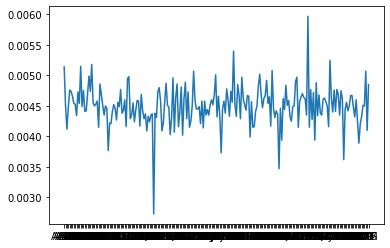

In [15]:
l2_grid = np.linspace(0.1,1.2,10)
risk_grid = np.linspace(0.01,0.8,10)

from pypfopt import objective_functions
t = X
mu = np.mean(t)
normalized = t-mu
Sigma = np.cov(normalized, rowvar=0)
best_port = []
max_ret = 0
for g in l2_grid:
    for d in risk_grid:
        ef = EfficientFrontier(mu, Sigma)
        ef.add_objective(objective_functions.L2_reg, gamma=g)
        w = ef.max_quadratic_utility(risk_aversion=d)
        # cleaned is a dict of weights instead of vector
        cleaned = pd.Series(dict(ef.clean_weights()))
        ret = (w*t).sum(axis=1)
        cum_ret = (1+ret).cumprod() - 1
        mean_ret = np.mean(ret)
        if mean_ret > max_ret:
            best_port = w
            max_ret = mean_ret
plt.plot(cleaned)


<p>Symmetry check on covariance matrix to double check that the problem has been optimized correctly</p>


In [16]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
check_symmetric(Sigma)

True


<h4 id="Filter-stocks-using-previous-batch's-HMM-state-decisions">Filter stocks using previous batch's HMM state decisions<a class="anchor-link" href="#Filter-stocks-using-previous-batch's-HMM-state-decisions">¶</a></h4>


In [29]:
%%capture
def filter_decisions(tickers):
    chosen_stocks = []
    temp = f.tail(28)
    for c in temp.columns:
        try:
            thresh = (temp[c].value_counts(normalize=True)*100)['buy']
            #print(thresh)
            if thresh >= 90:
                chosen_stocks.append(c)
        except:
            pass
    return chosen_stocks

filter_decisions(tickers)

['AAPL', 'ADBE', 'AGN', 'AIG', 'AMGN', 'APD', 'BRK.B', 'CAT', 'DG', 'FB', 'FIS', 'GM', 'GOOGL', 'GPN', 'HCA', 'HMC', 'ISRG', 'KMB', 'LIN', 'MDLZ', 'NVDA', 'PEP', 'PLD', 'RACE', 'RTN', 'SBUX', 'SHW', 'TSLA', 'V', 'VFC']


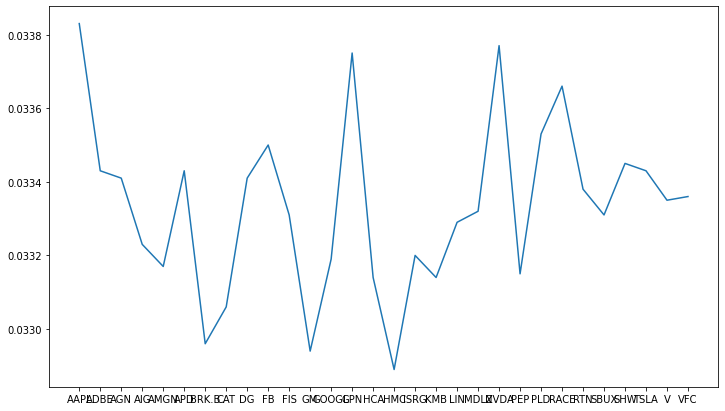

In [30]:
chosen_stocks = filter_decisions(tickers)
print(chosen_stocks)
t2 = t[chosen_stocks]
mu = np.mean(t2)
de_meaned = t2-mu
Sigma = np.cov(de_meaned, rowvar=0)
best_filter_port = []
max_filter_ret = 0
for g in l2_grid:
    for d in risk_grid:
        ef = EfficientFrontier(mu, Sigma)
        ef.add_objective(objective_functions.L2_reg, gamma=g)
        w2 = ef.max_quadratic_utility(risk_aversion=d)
        # cleaned is a dict of weights instead of vector
        cleaned = pd.Series(dict(ef.clean_weights()))
        ret = (w2*t2).sum(axis=1)
        cum_ret_filter = (1+ret).cumprod() - 1
        mean_ret_filter = np.mean(ret)
        if mean_ret_filter > max_filter_ret:
            best_filter_port = w
            max_filter_ret = mean_ret_filter
plt.plot(cleaned)


<h3 id="Comparison-of-Filtered-vs.-Unfiltered-Maximum-Quadratic-Utility-Portfolio-on-Validation-Batch">Comparison of Filtered vs. Unfiltered Maximum Quadratic Utility Portfolio on Validation Batch<a class="anchor-link" href="#Comparison-of-Filtered-vs.-Unfiltered-Maximum-Quadratic-Utility-Portfolio-on-Validation-Batch">¶</a></h3>



<p>Use first chunk to evaluate stock filter, use second chunk to calculate filtered and unfiltered MV portfolio weights, use third chunk as validation set</p>


In [20]:
new_start_date = datetime.datetime(2020, 1, 1)
new_end_date = datetime.datetime(2021, 1, 1)
top_n = 200
new_tickers = sorted(su.get_universe_tickers(top_n, start_date, end_date))
price_attrs = ['date','close', 'open', 'high', 'low']
new_data = su.get_equity_data(tickers, new_start_date, new_end_date, price_attrs)

new_X = new_data['close'].pct_change().fillna(0)

set(X.columns) - set(new_X.columns)

/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:681: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, query_params)
/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:321: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from siftools.data_utils
  cols, response = execute_query(query, params=query_params)
/Users/stevenstruglia/sif/sif/sifinfra/sif_utils.py:253: DeprecationWarning: execute_query is a deprecated function. sifinfra.sif_utils is a deprecated module and will be removed in a future version of sif. Please remove calls to this module and replace them with alternatives from

{'APC', 'CELG', 'SHPG', 'TFCF', 'WP'}

In [21]:
# We need to remove stocks that fell out of universe from MQU portfolios for previous batch
def remove_tickers(drop_tickers):
    for a in drop_tickers:
        try:
            del best_port[a]
            del best_filter_port[a]
        except:
            pass
        
remove_tickers(['APC', 'CELG', 'SHPG', 'TFCF', 'WP'])

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
unfiltered_MQU_returns = (best_port*new_X).sum(axis=1)
filtered_MQU_returns = (cleaned*new_X[chosen_stocks]).sum(axis=1)


<h4 id="Comparison-of-distribution-of-daily-returns">Comparison of distribution of daily returns<a class="anchor-link" href="#Comparison-of-distribution-of-daily-returns">¶</a></h4>


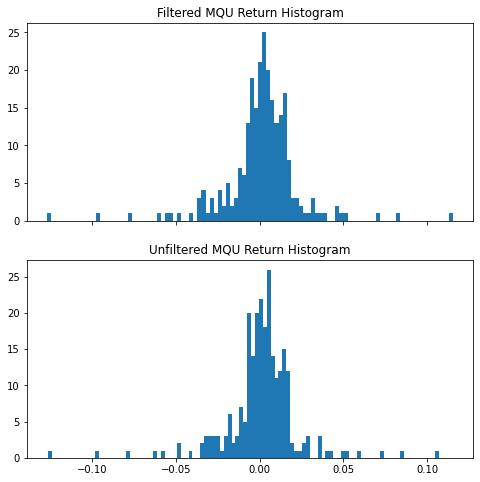

In [32]:
fig, axs = plt.subplots(2, sharex = True);
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0].title.set_text('Filtered MQU Return Histogram')
axs[1].title.set_text('Unfiltered MQU Return Histogram')
axs[0].hist(filtered_MQU_returns, bins = 100);
axs[1].hist(unfiltered_MQU_returns, bins = 100);


<p>Here we see that the distribution of daily returns in the filtered portfolio resembles the unfiltered fairly closely, though the central region is shifted to the right indicating a higher overall mean daily return as seen in the cell below.</p>



<h4 id="Averance-Difference-in-Daily-Percent-Returns">Averance Difference in Daily Percent Returns<a class="anchor-link" href="#Averance-Difference-in-Daily-Percent-Returns">¶</a></h4>


In [33]:
mean_diff = (filtered_MQU_returns - unfiltered_MQU_returns).sum()/len(unfiltered_MQU_returns)*100
mean_diff

0.014562421454966518

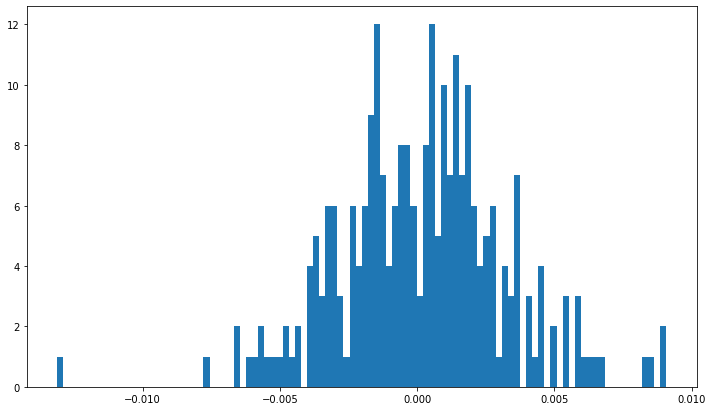

In [34]:
plt.hist((filtered_MQU_returns - unfiltered_MQU_returns), bins = 100);


<h4 id="Comparison-of-Cumulative-Returns">Comparison of Cumulative Returns<a class="anchor-link" href="#Comparison-of-Cumulative-Returns">¶</a></h4>


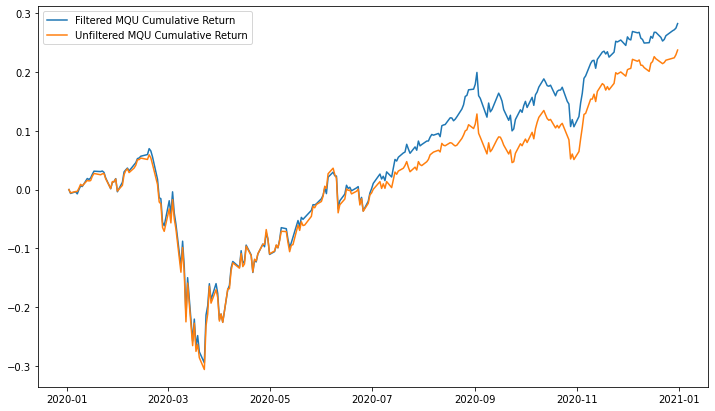

In [35]:
cumulative_u = (1+unfiltered_MQU_returns).cumprod() - 1
cumulative_f = (1+filtered_MQU_returns).cumprod() - 1

plt.rcParams["figure.figsize"] = (12,7)
plt.plot(cumulative_f, label = "Filtered MQU Cumulative Return")
plt.plot(cumulative_u, label = "Unfiltered MQU Cumulative Return")
plt.legend(loc='upper left')


<p>We see on average a 3% increase in daily cumulative return over the 3 month validation set when filtering the portfolio construction using the trained HMM model. This filter can extend to other convex portfolio allocation methods that utilize risk and reward in the objective, as well as a general filter for stock universe's prior to evaluating alphas that thrive in high variance markets. In the future, I would like to use this research as a stepping stone to filter other methods as well as examine further which allocation methods benefit the most from this filtering with a K-fold validation done on a longer historical period. In addition, I would also like to look at optimal values through hyperparameter optimization and cross-validation for batch sizes to ensure the best recall and accuracy measurements for each portfolio.</p>
